In [50]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyprogressivex
from time import time

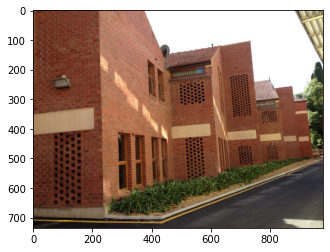

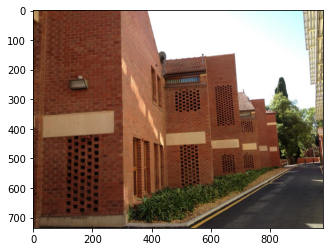

In [51]:
# Load the images
img1 = cv2.cvtColor(cv2.imread('img/unihouse1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/unihouse2.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [52]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.9
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

In [53]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def draw_matches(kps1, kps2, tentatives, img1, img2, mask):    
    matchesMask = mask.ravel().tolist()
    
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,decolorize(img2),kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return

In [54]:
def verify_pyprogressivex(img1, img2, kps1, kps2, tentatives):    
    correspondences = np.float32([ (kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives ]).reshape(-1,4)   
    threshold = 1.0
    
    homographies, labeling = pyprogressivex.findHomographies(
        np.ascontiguousarray(correspondences), 
        img1.shape[1], img1.shape[0], 
        img2.shape[1], img2.shape[0],
        threshold = threshold,
        conf = 0.5,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 200.0,
        maximum_tanimoto_similarity = 0.4,
        max_iters = 1000,
        minimum_point_number = 10,
        maximum_model_number = -1,
        sampler_id = 3,
        do_logging = False)    
    return homographies, labeling

In [55]:
t = time()

homographies, labeling = verify_pyprogressivex(img1, img2, kps1, kps2, tentatives)
model_number = homographies.size / 9

print ('Time = ', time()-t, ' sec')
print ('Models found = {}'.format(model_number))

Time =  0.2971963882446289  sec
Models found = 7.0


Drawing the points of the 1-th homography.


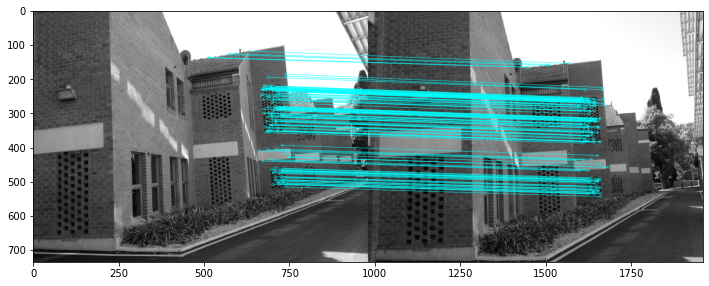

Drawing the points of the 2-th homography.


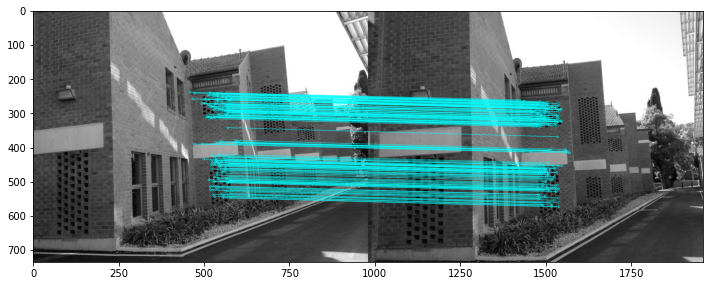

Drawing the points of the 3-th homography.


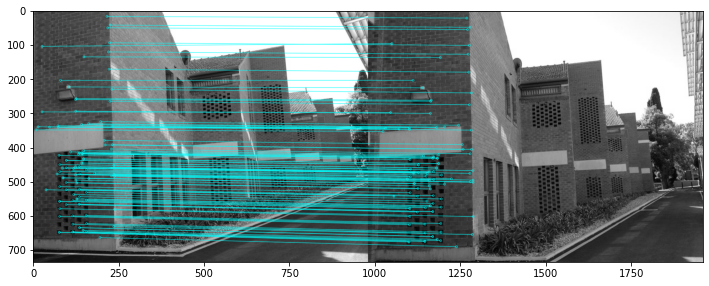

Drawing the points of the 4-th homography.


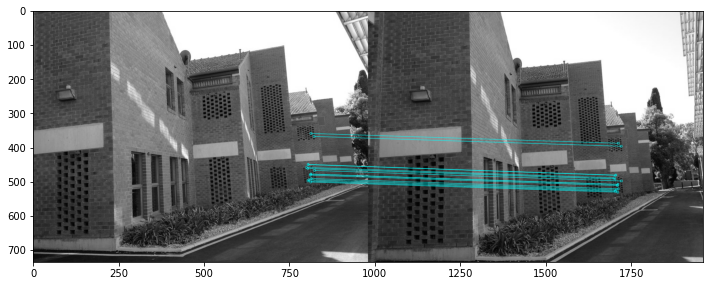

Drawing the points of the 5-th homography.


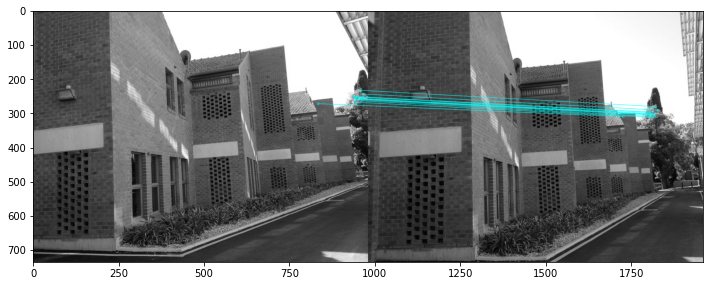

Drawing the points of the 6-th homography.


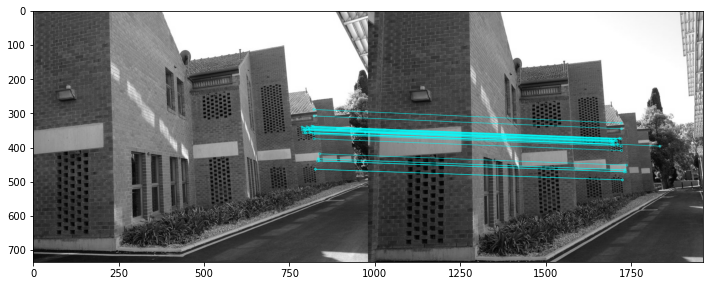

Drawing the points of the 7-th homography.


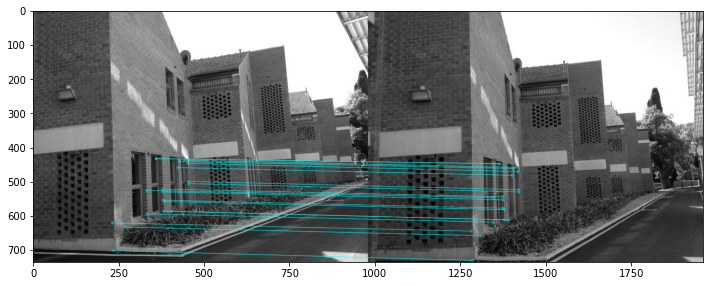

In [56]:
for hidx in np.arange(model_number):
    print("Drawing the points of the {}-th homography.".format(int(hidx + 1)))
    
    mask = np.zeros(len(labeling))
    indices = [i for i, e in enumerate(labeling) if e == hidx]
    mask[indices] = 1

    draw_matches(kps1, kps2, tentatives, img1, img2, mask )
